# Reject Inference Compiled Notebook #

### Packages ###

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score, recall_score

from imblearn.ensemble import BalancedRandomForestClassifier

import RIfunctions as ri

from scipy.stats import uniform

### Variables ###

In [2]:
RANDOM_STATE = 123
CROSS_VALIDATION = 10
results_df = pd.DataFrame()

In [3]:
# Read CSV files into pandas dataframe
application_df = pd.read_csv('input_file_1.csv', sep = ',', index_col=0)
accept_df = pd.read_csv('input_file_2.csv', sep = ',', index_col=0)

C:\Users\joshy\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# Need to split the dataset early for a consistent test dataset
# Removing instances from the application dataset so there is no knowledge

'''Exclude the period from the beginning of 2016 onward as it is noticed in time-series plots that this period has
 a significant portion of the expected defaults not reported yet. This would hence be biased.'''

accept_df['issue_d'] = pd.to_datetime(accept_df['issue_d'])
application_df['issue_d'] = pd.to_datetime(application_df['issue_d'])

application_df = application_df.loc[application_df['issue_d'] < '2016-1-1']
accept_df = accept_df.loc[accept_df['issue_d'] < '2016-1-1']

accept_train_df = accept_df.loc[accept_df['issue_d'] < accept_df['issue_d'].quantile(0.8)]
accept_test_df = accept_df.loc[accept_df['issue_d'] >= accept_df['issue_d'].quantile(0.8)]

print(application_df.shape)

application_df = application_df.loc[application_df['issue_d'] <= max(accept_train_df["issue_d"])]

application_df = application_df.drop('issue_d', axis=1)
accept_test_df = accept_test_df.drop('issue_d', axis=1)
accept_train_df = accept_train_df.drop('issue_d', axis=1)

print(application_df.shape)

(6351001, 6)
(4149346, 5)


## Application Dataset ##

### Pre-processing ###

In [5]:
# Remove instances with a small number of purpose values and align all values

application_df = ri.purposeCleaning(application_df)

<AxesSubplot:>

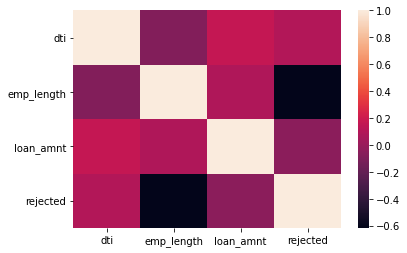

In [6]:
corr = application_df.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [7]:
# Get dummies for the purpose variable as it is an object which cannot be interperted   

application_df = pd.get_dummies(application_df, columns=['purpose'], drop_first=False)

In [8]:
# Train the model on the full dataset. We are trying to build a pre-existing, trained model, not a new model.

y_train = application_df['rejected']
X_train = application_df.drop(['rejected'], axis=1)

In [9]:
neg, pos = np.bincount(application_df['rejected'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 3931748
    Positive: 3432231 (87.30% of total)



### Logistic Regression Model for Application Dataset ###

In [10]:
# # # Optimisation

# pipeline_sgdlogreg = Pipeline([
#     # Alternative is KNNImputer
#     ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
#     ('scaler', StandardScaler(copy=False)),
#     ('model',LogisticRegression(
#         class_weight='balanced',
#         random_state=RANDOM_STATE,
#         n_jobs=-2,
#         warm_start=True
#         )
#     )
# ])

# param_grid_sgdlogreg = {
#     'model__solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']
# }

# grid_sgdlogreg = GridSearchCV(
#     estimator=pipeline_sgdlogreg,
#     param_grid=param_grid_sgdlogreg,
#     scoring='roc_auc',
#     pre_dispatch=3,
#     n_jobs=-2,
#     cv=CROSS_VALIDATION,
#     verbose=1,
#     return_train_score=False
# )

# grid_sgdlogreg.fit(X_train, y_train)

# print(grid_sgdlogreg.best_estimator_,grid_sgdlogreg.best_params_, grid_sgdlogreg.best_score_)

In [11]:
# Hyperparemeters already optimised

pipeline_logreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000, 
        tol = 1e-3,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        warm_start=True,
        solver = 'lbfgs'
        )
    )
])

In [12]:
pipeline_logreg.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                ('scaler', StandardScaler(copy=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=123, tol=0.001,
                                    warm_start=True))])

In [13]:
cv_scores_lr = cross_val_score(estimator= pipeline_logreg, X=X_train, y=y_train, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("The cross-validation AUC for optimised LR model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_lr), std(cv_scores_lr)))

The cross-validation AUC for optimised LR model after a 10 fold cross validation: 0.913 (0.016)


In [14]:
# Scores of each application and model performance

y_score = pipeline_logreg.predict_proba(X_train)[:,1]

y_score_flag = [int(round(i)) for i in y_score]

print(roc_auc_score(y_train, y_score), recall_score(y_train, y_score_flag, pos_label=1), recall_score(y_train, y_score_flag, pos_label=0))

0.9149395779299506 0.9099728427369836 0.774380051129391


Confusion matrix, without normalization
[[ 386816  112701]
 [ 308994 3123237]]


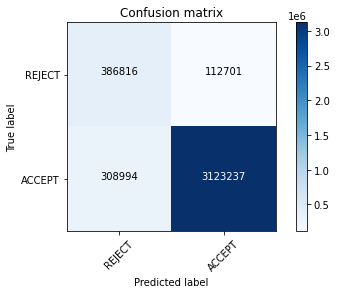

In [15]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_train, y_score_flag)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["REJECT", "ACCEPT"])

plt.show()

In [16]:
results_df = ri.AppendResults(df=results_df, title="LR Application Dataset",
AUC_scores=cv_scores_lr, y_test=y_train, y_score=y_score)


### Save LR Results ###

In [17]:
# Add score column to the dataframe

application_df['score'] = np.hstack(y_score)

In [18]:
# # Undummy the purpose column

def undummy(d):
    return d.dot(d.columns)

application_df = application_df.assign(purpose=application_df.filter(regex='^purpose').pipe(undummy))
application_df['purpose'] = application_df['purpose'].str.replace("purpose_","")
application_df = application_df[application_df.columns.drop(list(application_df.filter(regex="purpose_")))]

In [19]:
# Save to CSV file

application_df.to_csv('AR Scores.csv', mode='w+')

## Accepted Loans Dataset ##

### Pre-processing ###

In [20]:
# Rows with Educational and Renewable Energy purpose have been dropped in the application dataset

accept_train_df = accept_train_df.drop(accept_train_df[accept_train_df['purpose'] == 'educational'].index)
accept_test_df = accept_test_df.drop(accept_test_df[accept_test_df['purpose'] == 'educational'].index)

accept_train_df = accept_train_df.drop(accept_train_df[accept_train_df['purpose'] == 'renewable_energy'].index)
accept_test_df = accept_test_df.drop(accept_test_df[accept_test_df['purpose'] == 'renewable_energy'].index)

In [21]:
all_cols = list(accept_df.columns)
all_cols.remove('charged_off')
all_cols.remove('issue_d')

to_drop_categorical = ['home_ownership', 'verification_status', 'purpose', 'application_type']

for i in to_drop_categorical:

    all_cols.remove(i)

<AxesSubplot:>

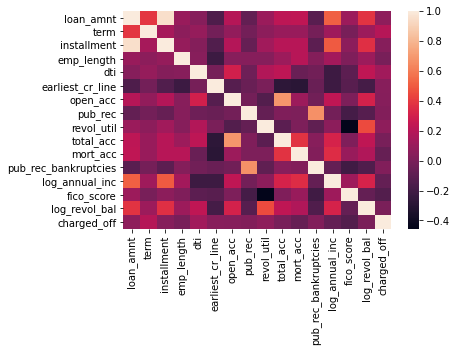

In [22]:
corr = accept_df.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [23]:
# Application value did not exist in the training set but did in the test

accept_train_df["at_Joint App"] = 0

accept_train_df_all = pd.get_dummies(accept_train_df,prefix=["ho","vs","purp","at"], columns=['home_ownership', 'verification_status', 'purpose', 'application_type'], drop_first=False)
accept_test_df_all = pd.get_dummies(accept_test_df,prefix=["ho","vs","purp","at"], columns=['home_ownership', 'verification_status', 'purpose', 'application_type'], drop_first=False)


In [24]:
scaler_all = StandardScaler(copy=False)

accept_train_df_all[all_cols] = accept_train_df_all[all_cols].fillna(accept_train_df_all[all_cols].mean())
accept_test_df_all[all_cols] = accept_test_df_all[all_cols].fillna(accept_test_df_all[all_cols].mean())

accept_train_df_all[all_cols] = scaler_all.fit_transform(accept_train_df_all[all_cols], accept_train_df_all['charged_off'])
accept_test_df_all[all_cols] = scaler_all.transform(accept_test_df_all[all_cols])

In [25]:
neg, pos = np.bincount(accept_train_df_all['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(accept_test_df_all['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 499517
    Positive: 91418 (18.30% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [26]:
y_train = accept_train_df_all['charged_off']
y_test = accept_test_df_all['charged_off']

X_train = accept_train_df_all.drop('charged_off', axis=1)
X_test = accept_test_df_all.drop('charged_off', axis=1)


### Random Forest Model ###

In [27]:
# Hyperparameter tuning. Took over 11 hours to run.

# best_hyperparams, best_rf = ri.RandomForestTuning(BalancedRandomForestClassifier(), X_train, y_train, filename = "./random_forest.joblib", cv = CROSS_VALIDATION)
# print("Best hyperparameters: \n", best_hyperparams )

In [28]:
model = joblib.load("./random_forest.joblib")
print(model.get_params())
model.fit(X_train, y_train)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(max_depth=5, n_estimators=50)

In [29]:
cv_scores_train = cross_val_score(estimator= model, X=X_train, y=y_train, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train), std(cv_scores_train)))

cv_scores_test = cross_val_score(estimator= model, X=X_test, y=y_test, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test), std(cv_scores_test)))

(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.689 (0.014)
(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.693 (0.007)


In [30]:
yhat = model.predict(X_test)
print(roc_auc_score(y_test, yhat), recall_score(y_test, yhat, pos_label=1), recall_score(y_test, yhat, pos_label=0))

c:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.6222847683036784 0.6037639748389233 0.6408055617684336


Confusion matrix, without normalization
[[68761 38543]
 [15559 23708]]


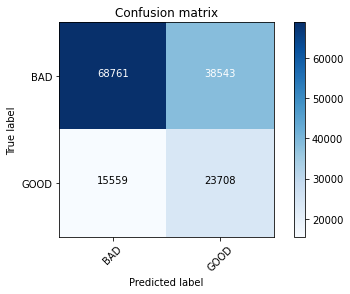

In [31]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"])

plt.show()

In [32]:
results_df = ri.AppendResults(df=results_df, title="Full RF - Accepts Only",
AUC_scores=cv_scores_train, y_test=y_test, y_score=yhat)

## Matching Characteristics ##

### Pre-processing ###

In [33]:
numerical_cols = ['loan_amnt', 'emp_length', 'dti']
match_cols = ['loan_amnt', 'emp_length', 'dti','purpose','charged_off']
excl_cols = ['charged_off','weight','score','rejected','accept_score']

accept_train_df_reduced = accept_train_df[match_cols]
accept_test_df_reduced = accept_test_df[match_cols]

In [34]:
accept_train_df_reduced = pd.get_dummies(accept_train_df_reduced, prefix=["purp"], columns=['purpose'], drop_first=False)
accept_test_df_reduced = pd.get_dummies(accept_test_df_reduced, prefix=["purp"], columns=['purpose'], drop_first=False)

In [35]:
scaler_reduced = StandardScaler(copy=False)

accept_train_df_reduced[numerical_cols] = accept_train_df_reduced[numerical_cols].fillna(accept_train_df_reduced[numerical_cols].mean())
accept_test_df_reduced[numerical_cols] = accept_test_df_reduced[numerical_cols].fillna(accept_test_df_reduced[numerical_cols].mean())

accept_train_df_reduced[numerical_cols] = scaler_reduced.fit_transform(accept_train_df_reduced[numerical_cols], accept_train_df_reduced['charged_off'])
accept_test_df_reduced[numerical_cols] = scaler_reduced.transform(accept_test_df_reduced[numerical_cols])

In [36]:
neg, pos = np.bincount(accept_train_df_reduced['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(accept_test_df_reduced['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 499517
    Positive: 91418 (18.30% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [37]:
y_train_reduced = accept_train_df_reduced['charged_off']
y_test_reduced = accept_test_df_reduced['charged_off']

X_train_reduced = accept_train_df_reduced.drop('charged_off', axis=1)
X_test_reduced = accept_test_df_reduced.drop('charged_off', axis=1)

### Random Forest Model ###

In [38]:
# # # Hyperparameter tuning. Took over 11 hours to run.
# # May be interesting to see if the optimised hyperparameters change with reduced characteristics

# best_hyperparams, best_rf = ri.RandomForestTuning(BalancedRandomForestClassifier(), X_train_reduced, y_train_reduced, filename = "./random_forest_reduced.joblib", cv = CROSS_VALIDATION)

# print("Best hyperparameters: \n", best_hyperparams )

In [39]:
model_reduced = joblib.load("./random_forest_reduced.joblib")
print(model_reduced.get_params())
model_reduced.fit(X_train_reduced, y_train_reduced)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [40]:
cv_scores_train = cross_val_score(estimator= model_reduced, X=X_train_reduced, y=y_train_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for Reduced Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train), std(cv_scores_train)))

cv_scores_test = cross_val_score(estimator= model_reduced, X=X_test_reduced, y=y_test_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for Reduced Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test), std(cv_scores_test)))

(Training Set) The cross-validation AUC for Reduced Random Forest model after a 10 fold cross validation: 0.605 (0.012)
(Test Set) The cross-validation AUC for Reduced Random Forest model after a 10 fold cross validation: 0.617 (0.007)


In [41]:
yhat_reduced = model_reduced.predict(X_test_reduced)
print(roc_auc_score(y_test_reduced, yhat_reduced), recall_score(y_test_reduced, yhat_reduced, pos_label=1), recall_score(y_test_reduced, yhat_reduced, pos_label=0))

0.5826396672074363 0.6253087834568467 0.5399705509580258


Confusion matrix, without normalization
[[57941 49363]
 [14713 24554]]


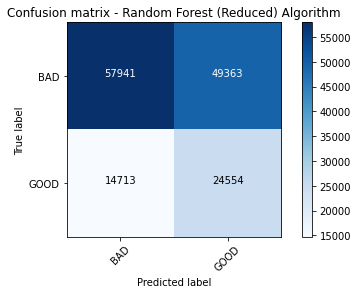

In [42]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test_reduced, yhat_reduced)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"],
                      title='Confusion matrix - Random Forest (Reduced) Algorithm')

plt.show()

In [43]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Accepts Only",
AUC_scores=cv_scores_train, y_test=y_test_reduced, y_score=yhat_reduced)

## Reject Inference Techniques ##

In [44]:
rejected = application_df.loc[application_df["rejected"] == 1]

### Simple Assignment ###

In [46]:
ri_df = pd.concat([accept_train_df, rejected], axis=0, ignore_index=True)
ri_df.loc[ri_df['rejected'] == 1, 'charged_off'] = 1

In [47]:
train_df_sa = ri_df[match_cols]
train_df_sa = pd.get_dummies(train_df_sa, prefix=["purp"], columns=['purpose'], drop_first=False)

In [48]:
train_df_sa[numerical_cols] = train_df_sa[numerical_cols].fillna(train_df_sa[numerical_cols].mean())
train_df_sa[numerical_cols] = scaler_reduced.transform(train_df_sa[numerical_cols])

In [49]:
neg, pos = np.bincount(train_df_sa['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(accept_test_df_reduced['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 3931748
    Positive: 3523649 (89.62% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [50]:
y_train_sa = train_df_sa['charged_off']
X_train_sa = train_df_sa.drop('charged_off', axis=1)

In [51]:
model_ri = joblib.load("./random_forest_reduced.joblib")
print(model_ri.get_params())

model_ri.fit(X_train_sa, y_train_sa)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [52]:
cv_scores_train_sa = cross_val_score(estimator= model_ri, X=X_train_sa, y=y_train_sa, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model with SA RI after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train_sa), std(cv_scores_train_sa)))

cv_scores_test_sa = cross_val_score(estimator= model_ri, X=X_test_reduced, y=y_test_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for optimised Random Forest model with SA RI after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test_sa), std(cv_scores_test_sa)))

(Training Set) The cross-validation AUC for optimised Random Forest model with SA RI after a 10 fold cross validation: 0.948 (0.040)
(Test Set) The cross-validation AUC for optimised Random Forest model with SA RI after a 10 fold cross validation: 0.617 (0.007)


In [53]:
yhat_sa = model_ri.predict(X_test_reduced)
print(roc_auc_score(y_test_reduced, yhat_sa), recall_score(y_test_reduced, yhat_sa, pos_label=1), recall_score(y_test_reduced, yhat_sa, pos_label=0))

0.5029583345800385 0.09241857030076145 0.9134980988593155


Confusion matrix, without normalization
[[98022  9282]
 [35638  3629]]


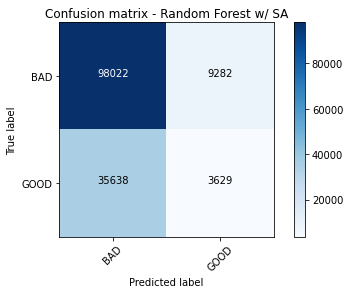

In [54]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test_reduced, yhat_sa)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"],
                      title='Confusion matrix - Random Forest w/ SA')

plt.show()

In [55]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Simple Assignment",
AUC_scores=cv_scores_train_sa, y_test=y_test_reduced, y_score=yhat_sa)

### Random Assignment ###

In [56]:
neg, pos = np.bincount(accept_train_df['charged_off'])
total = neg + pos
reject_rate = pos / total

random_assign_rate = reject_rate * 3.5

print(reject_rate)
print(random_assign_rate)

# Higher the fraction, bigger the sample
split_BAD = rejected.sample(frac = random_assign_rate, random_state=RANDOM_STATE)
split_GOOD = rejected.drop(split_BAD.index)

split_BAD['charged_off'] = 1
split_GOOD = split_GOOD.assign(charged_off= 0)

ri_df = pd.concat([accept_train_df, split_BAD, split_GOOD], axis=0, ignore_index=True)

0.1830127903554834
0.6405447662441919


In [57]:
train_df_ra = ri_df[match_cols]
train_df_ra = pd.get_dummies(train_df_ra, prefix=["purp"], columns=['purpose'], drop_first=False)

In [58]:
train_df_ra[numerical_cols] = train_df_ra[numerical_cols].fillna(train_df_ra[numerical_cols].mean())
train_df_ra[numerical_cols] = scaler_reduced.transform(train_df_ra[numerical_cols])

In [59]:
neg, pos = np.bincount(train_df_ra['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(accept_test_df_reduced['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 3931748
    Positive: 2289916 (58.24% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [60]:
y_train_ra = train_df_ra['charged_off']
X_train_ra = train_df_ra.drop('charged_off', axis=1)

In [61]:
model_ri.fit(X_train_ra, y_train_ra)

BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [62]:
cv_scores_train_ra = cross_val_score(estimator= model_ri, X=X_train_ra, y=y_train_ra, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model with RA RI after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train_ra), std(cv_scores_train_ra)))

cv_scores_test_ra = cross_val_score(estimator= model_ri, X=X_test_reduced, y=y_test_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for optimised Random Forest model with RA RI after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test_ra), std(cv_scores_test_ra)))

(Training Set) The cross-validation AUC for optimised Random Forest model with RA RI after a 10 fold cross validation: 0.571 (0.168)
(Test Set) The cross-validation AUC for optimised Random Forest model with RA RI after a 10 fold cross validation: 0.617 (0.007)


In [63]:
yhat_ra = model_reduced.predict(X_test_reduced)
print(roc_auc_score(y_test_reduced, yhat_ra), recall_score(y_test_reduced, yhat_ra, pos_label=1), recall_score(y_test_reduced, yhat_ra, pos_label=0))

0.5826396672074363 0.6253087834568467 0.5399705509580258


Confusion matrix, without normalization
[[57941 49363]
 [14713 24554]]


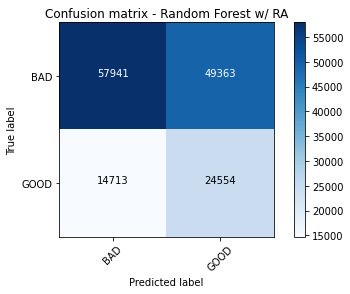

In [64]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test_reduced, yhat_ra)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"],
                      title='Confusion matrix - Random Forest w/ RA')

plt.show()

In [65]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Random Assignment",
AUC_scores=cv_scores_train_ra, y_test=y_test_reduced, y_score=yhat_ra)

### Augmentation ###

In [66]:
aug_df = application_df.sort_values(by="score", ascending = False)
aug_df['accept_score'] = 1 - aug_df['score']
intervals = np.array_split(aug_df, 10)

for band in intervals:
    accepts = band.loc[band["rejected"] == 0, "rejected"].count()
    rejects = band.loc[band["rejected"] == 1, "rejected"].count()
    weight = (rejects + accepts) / accepts
    band.drop(band[band['rejected'] == 1].index, inplace=True)
    band['weight'] = weight

aug_df=pd.concat(intervals)
aug_df.drop_duplicates(inplace=True)
ri_df = accept_train_df.merge(aug_df, on=["dti","emp_length","loan_amnt","purpose"], how = 'inner')
print(ri_df.shape[0] - accept_train_df.shape[0])
ri_df.head()

0


,loan_amnt,term,installment,emp_length,home_ownership,verification_status,purpose,dti,earliest_cr_line,open_acc,...,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,at_Joint App,rejected,score,accept_score,weight
0,15000.0,60,336.64,10.0,RENT,Source Verified,debt_consolidation,12.03,1994,6.0,...,0.0,4.892100,752.0,5.139907,0,0,0,0.008719,0.991281,1.516196
1,15000.0,36,476.30,10.0,MORTGAGE,Not Verified,debt_consolidation,12.03,1997,8.0,...,0.0,4.929424,752.0,4.583505,0,0,0,0.008719,0.991281,1.516196
2,15000.0,36,509.25,10.0,RENT,Not Verified,debt_consolidation,12.03,1975,8.0,...,1.0,4.602071,677.0,3.800854,0,0,0,0.008719,0.991281,1.516196
3,15000.0,36,502.00,10.0,MORTGAGE,Verified,debt_consolidation,12.03,1997,8.0,...,1.0,4.544080,707.0,4.049140,0,0,0,0.008719,0.991281,1.516196
4,15000.0,60,440.19,10.0,MORTGAGE,Verified,debt_consolidation,12.03,2002,9.0,...,0.0,4.568213,677.0,3.816308,1,0,0,0.008719,0.991281,1.516196


In [67]:
train_df_aug_all = pd.get_dummies(ri_df,prefix=["ho","vs","purp","at"], columns=['home_ownership', 'verification_status', 'purpose', 'application_type'], drop_first=False)
train_df_aug_all[all_cols] = train_df_aug_all[all_cols].fillna(train_df_aug_all[all_cols].mean())
train_df_aug_all[all_cols] = scaler_all.transform(train_df_aug_all[all_cols])

In [68]:
neg, pos = np.bincount(train_df_aug_all['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(accept_test_df_all['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 499517
    Positive: 91418 (18.30% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [69]:
y_train_aug_all = train_df_aug_all['charged_off']
X_train_aug_all = train_df_aug_all.drop(excl_cols, axis=1)
train_weights_aug_all = train_df_aug_all['weight']

In [70]:
model.fit(X_train_aug_all, y_train_aug_all, sample_weight=train_weights_aug_all)

BalancedRandomForestClassifier(max_depth=5, n_estimators=50)

In [71]:
cv_scores_train_aug_all = cross_val_score(estimator= model, X=X_train_aug_all, y=y_train_aug_all, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Full Random Forest model with Augmentation after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train_aug_all), std(cv_scores_train_aug_all)))

cv_scores_test_ra_aug_all = cross_val_score(estimator= model, X=X_test, y=y_test, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for optimised Full Random Forest model with Augmentation after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test_ra_aug_all), std(cv_scores_test_ra_aug_all)))

(Training Set) The cross-validation AUC for optimised Full Random Forest model with Augmentation after a 10 fold cross validation: 0.688 (0.012)
(Test Set) The cross-validation AUC for optimised Full Random Forest model with Augmentation after a 10 fold cross validation: 0.692 (0.007)


In [72]:
yhat_aug_all = model.predict(X_test)
print(roc_auc_score(y_test, yhat_aug_all), recall_score(y_test, yhat_aug_all, pos_label=1), recall_score(y_test, yhat_aug_all, pos_label=0))

c:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.6189605741666497 0.7484146993658798 0.4895064489674197


Confusion matrix, without normalization
[[52526 54778]
 [ 9879 29388]]


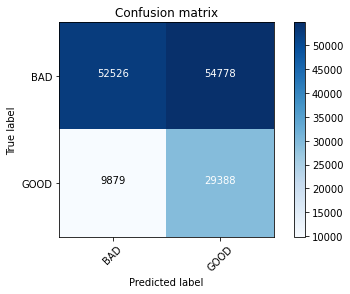

In [73]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, yhat_aug_all)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"])

plt.show()

In [74]:
results_df = ri.AppendResults(df=results_df, title="Full RF - Augmentation",
AUC_scores=cv_scores_train_aug_all, y_test=y_test, y_score=yhat_aug_all)

### Parcelling ###

In [75]:
aug_df = application_df.sort_values(by="score", ascending = False)

parcel_df_reject = aug_df.loc[aug_df["rejected"] == 1]
parcel_df_accept = aug_df.loc[aug_df["rejected"] == 0]

parcel_df_accept = parcel_df_accept.drop_duplicates()

accept_scores = accept_train_df.merge(parcel_df_accept, on=["dti","emp_length","loan_amnt","purpose"], how = 'left')

# unsure of the number of intervals
reject_intervals = np.array_split(parcel_df_reject, 10)
accept_intervals = np.array_split(accept_scores, 10)

counter = 0

for reject_band in reject_intervals:

    neg, pos = np.bincount(accept_intervals[counter]['charged_off'])
    reject_rate = pos / (neg + pos)
    assign_rate = reject_rate * 3.5

    # Higher the fraction, bigger the sample
    split_BAD = reject_band.sample(frac = assign_rate, random_state=RANDOM_STATE)
    split_GOOD = reject_band.drop(split_BAD.index)

    split_BAD['charged_off'] = 1
    split_GOOD = split_GOOD.assign(charged_off= 0)
    
    accept_scores = pd.concat([accept_scores, split_BAD, split_GOOD], axis=0, ignore_index=True)
    counter = counter + 1

In [76]:
train_df_PARCEL_reduced = accept_scores[match_cols]
train_df_PARCEL_reduced = pd.get_dummies(train_df_PARCEL_reduced, prefix=["purp"], columns=['purpose'], drop_first=False)
train_df_PARCEL_reduced[numerical_cols] = train_df_PARCEL_reduced[numerical_cols].fillna(train_df_PARCEL_reduced[numerical_cols].mean())
train_df_PARCEL_reduced[numerical_cols] = scaler_reduced.transform(train_df_PARCEL_reduced[numerical_cols])

In [77]:
neg, pos = np.bincount(train_df_PARCEL_reduced['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(accept_test_df_reduced['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 3931748
    Positive: 2289915 (58.24% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [78]:
y_train_PARCEL_reduced = train_df_PARCEL_reduced['charged_off']
X_train_PARCEL_reduced = train_df_PARCEL_reduced.drop(['charged_off'], axis=1)

In [79]:
model_ri.fit(X_train_PARCEL_reduced, y_train_PARCEL_reduced)

BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [80]:
cv_scores_train_PARCEL_reduced = cross_val_score(estimator= model_ri, X=X_train_PARCEL_reduced, y=y_train_PARCEL_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Reduced Random Forest model with Parcelling after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train_PARCEL_reduced), std(cv_scores_train_PARCEL_reduced)))

cv_scores_test_PARCEL_reduced = cross_val_score(estimator= model_ri, X=X_test_reduced, y=y_test_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for optimised Reduced Random Forest model with Parcelling after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test_PARCEL_reduced), std(cv_scores_test_PARCEL_reduced)))

(Training Set) The cross-validation AUC for optimised Reduced Random Forest model with Parcelling after a 10 fold cross validation: 0.386 (0.275)
(Test Set) The cross-validation AUC for optimised Reduced Random Forest model with Parcelling after a 10 fold cross validation: 0.617 (0.007)


In [81]:
yhat_PARCEL_reduced = model_ri.predict(X_test_reduced)
print(roc_auc_score(y_test_reduced, yhat_PARCEL_reduced), recall_score(y_test_reduced, yhat_PARCEL_reduced, pos_label=1), recall_score(y_test_reduced, yhat_PARCEL_reduced, pos_label=0))

0.5056468471983496 0.05974482389792956 0.9515488704987699


Confusion matrix, without normalization
[[102105   5199]
 [ 36921   2346]]


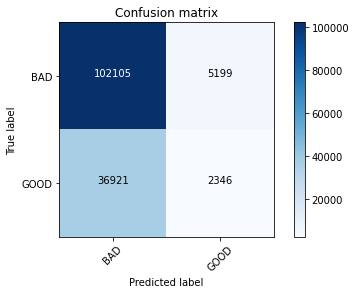

In [82]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, yhat_PARCEL_reduced)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"])

plt.show()

In [83]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Parcelling",
AUC_scores=cv_scores_train_PARCEL_reduced, y_test=y_test, y_score=yhat_PARCEL_reduced)

### Extrapolation ###

In [87]:
rejects_extrapolation = rejected.drop(['rejected','score'], axis=1)
rejects_extrapolation = pd.get_dummies(rejects_extrapolation, prefix=["purp"], columns=['purpose'], drop_first=False)
# rejects_extrapolation['charged_off'] = 0

In [88]:
rejects_extrapolation[numerical_cols] = rejects_extrapolation[numerical_cols].fillna(rejects_extrapolation[numerical_cols].mean())
rejects_extrapolation[numerical_cols] = scaler_reduced.transform(rejects_extrapolation[numerical_cols])

In [89]:
reject_bad_prob = model_reduced.predict_proba(rejects_extrapolation)

c:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [90]:
neg, pos = np.bincount(accept_train_df_reduced['charged_off'])
total = neg + pos
rate = 100 * pos / total

In [91]:
# No rejects scored below the rate because of the lack of variables
# Suggestion for further work would be to change the rates

print("Rate: ", rate)
rate = 1 - (rate/100)

rejects_extrapolation['bad_prob'] = reject_bad_prob[:,1]
rejects_extrapolation['charged_off'] = np.where(rejects_extrapolation['bad_prob'] >= rate, 1, 0)
rejects_extrapolation.drop('bad_prob', axis=1, inplace=True)

train_df_EXTRAPOLATION_reduced = pd.concat([accept_train_df_reduced, rejects_extrapolation])

Rate:  18.30127903554834


In [92]:
neg, pos = np.bincount(train_df_EXTRAPOLATION_reduced['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(accept_test_df_reduced['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 3931748
    Positive: 91418 (2.33% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [96]:
y_train_EXTRAPOLATION_reduced = train_df_EXTRAPOLATION_reduced['charged_off']
X_train_EXTRAPOLATION_reduced = train_df_EXTRAPOLATION_reduced.drop(['charged_off'], axis=1)

In [97]:
model_ri.fit(X_train_EXTRAPOLATION_reduced, y_train_EXTRAPOLATION_reduced)

# 10 fold cross roc_auc
cv_scores_train_extrapolated = cross_val_score(estimator= model_ri, X=X_train_EXTRAPOLATION_reduced, y=y_train_EXTRAPOLATION_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for Reduced Random Forest - Exrapolated RI model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train_extrapolated), std(cv_scores_train_extrapolated)))

cv_scores_test_extrapolated = cross_val_score(estimator= model_ri, X=X_test_reduced, y=y_test_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for Reduced Random Forest - Exrapolated RI after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test_extrapolated), std(cv_scores_test_extrapolated)))

(Training Set) The cross-validation AUC for Reduced Random Forest - Exrapolated RI model after a 10 fold cross validation: 0.916 (0.135)
(Test Set) The cross-validation AUC for Reduced Random Forest - Exrapolated RI after a 10 fold cross validation: 0.617 (0.007)


In [98]:
yhat_EXTRAPOLATION_reduced = model_ri.predict(X_test_reduced)
print(roc_auc_score(y_test_reduced, yhat_EXTRAPOLATION_reduced), recall_score(y_test_reduced, yhat_EXTRAPOLATION_reduced, pos_label=1), recall_score(y_test_reduced, yhat_EXTRAPOLATION_reduced, pos_label=0))

0.4987805044551676 0.9113759645503858 0.08618504435994931


Confusion matrix, without normalization
[[ 9248 98056]
 [ 3480 35787]]


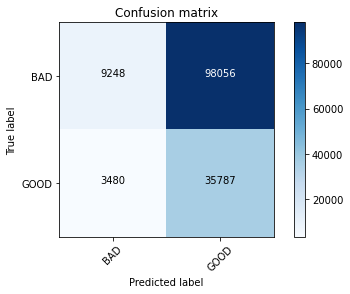

In [99]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, yhat_EXTRAPOLATION_reduced)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"])

plt.show()

In [100]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Extrapolation",
AUC_scores=cv_scores_train_extrapolated, y_test=y_test, y_score=yhat_EXTRAPOLATION_reduced)

In [102]:
# Save to CSV file

results_df.to_csv('Results.csv', mode='w+')